In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier

In [2]:
data_test = pd.read_csv('/Users/nikitaseleznev/Downloads/Test-2.csv')
data_train = pd.read_csv('/Users/nikitaseleznev/Downloads/Train-2.csv')
data_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,616,0.0,4,43,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,1738000
1,1,2011-1,112,0.0,3,33,1,0,15.0,1.0,...,0,0,0,0,0,0,0,0,0,1169000
2,2,2011-1,230,NaN,9,34,1,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,2821000
3,3,2011-1,302,1.0,4,60,3,0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,5714000
4,4,2011-1,578,0.0,3,49,2,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,1660000


In [3]:
data_train.isna().mean() != 0

id            False
date          False
street_id     False
build_tech     True
floor         False
area          False
rooms         False
balcon        False
metro_dist     True
g_lift         True
n_photos      False
kw1           False
kw2           False
kw3           False
kw4           False
kw5           False
kw6           False
kw7           False
kw8           False
kw9           False
kw10          False
kw11          False
kw12          False
kw13          False
price         False
dtype: bool

In [4]:
def column_is_na(data):
    data_not_na = data[data.notna()]
    data_na = data[data.isna()]
    return data_not_na, data_na

In [5]:
# Bootstrap для колонок признаков, которые имеют пропуски
def get_bootstrap_samples(data, n_samples):
    data = column_is_na(data)[0]
    data = data.values
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return np.round(boundaries, 4)

In [7]:
build_tech_scores = [np.mean(sample) for sample in get_bootstrap_samples(data_train['build_tech'], 5000)]
g_lift_scores = [np.mean(sample) for sample in get_bootstrap_samples(data_train['g_lift'], 5000)]
metro_dist_scores = [np.mean(sample) for sample in get_bootstrap_samples(data_train['metro_dist'], 5000)]

In [8]:
int1 = stat_intervals(build_tech_scores, 0.5)
int2 = stat_intervals(g_lift_scores, 0.5)
int3 = stat_intervals(metro_dist_scores, 0.5)
int123 = [int1, int3, int2]
print ('build_tech: mean interval: ',  int1 , '| from :', data_train['build_tech'][data_train['build_tech'].notna()].unique())
print()
print ('g_lift: mean interval: ',  int2, '| from :', data_train['g_lift'][data_train['g_lift'].notna()].unique())
print()
print ('metro_dist: mean interval: ',  int3, '| from :', np.sort(data_train['metro_dist'][data_train['metro_dist'].notna()].unique()))

build_tech: mean interval:  [0.5283 0.5313] | from : [0. 1. 2.]

g_lift: mean interval:  [0.4985 0.5011] | from : [1. 0.]

metro_dist: mean interval:  [21.9008 21.9382] | from : [ 0.  5. 10. 15. 20. 25. 30.]


In [9]:
data_tr = data_train.copy()
for i, elem in enumerate([c for c in data_tr.columns if data_tr[c].isna().mean() != 0]):
    data_tr[elem] = data_tr[elem].fillna(value=np.round(int123[i][1]))

12it [00:01,  6.76it/s]


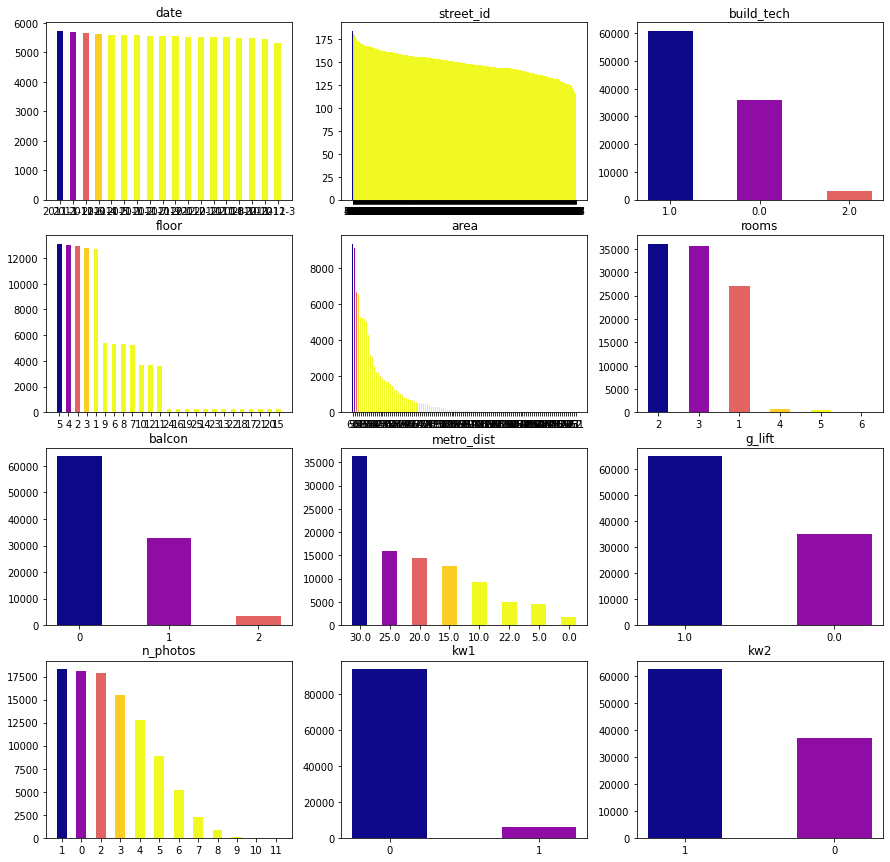

In [10]:
# распределения train, если заполнять округленными значениями из интервалов
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

ax = ax.ravel()
width = 0.15

for i, column in tqdm(enumerate(data_tr.columns[1:13])):
    x = np.arange(0, 0.3 * len(data_tr['{}'.format(column)].value_counts()), 0.3)
    
    tick_label = data_tr['{}'.format(column)].value_counts().index
    
    ax[i].set_title('{}'.format(column))
    ax[i].bar(x, 
              data_tr['{}'.format(column)].value_counts(), 
              width, tick_label=tick_label,
              color= cm.plasma(x))

In [11]:
# датасет для metro_dist чтобы далее заполнить nanы
data_X_for_metro_dist = data_train.drop(['date', 'metro_dist', 'n_photos', 'floor', 'rooms'], 1)
data_X_for_metro_dist['build_tech'] = data_X_for_metro_dist['build_tech'].fillna(value=1)
data_X_for_metro_dist['g_lift'] = data_X_for_metro_dist['g_lift'].fillna(value=1)

X_for_metro_dist = data_X_for_metro_dist[data_train['metro_dist'].notna()]


Y_for_metro_dist = data_train['metro_dist']
Y_for_metro_dist = Y_for_metro_dist[data_train['metro_dist'].notna()]

X_pred_metro_dist = data_X_for_metro_dist[data_train['metro_dist'].isna()]

In [12]:
# датасет для build_tech чтобы далее заполнить nanы
data_X_for_build_tech = data_train.drop(['date', 'build_tech', 'n_photos'], 1)
data_X_for_build_tech['metro_dist'] = data_X_for_build_tech['metro_dist'].fillna(value=20)
data_X_for_build_tech['g_lift'] = data_X_for_build_tech['g_lift'].fillna(value=1)

X_for_build_tech = data_X_for_build_tech[data_train['build_tech'].notna()]


Y_for_build_tech = data_train['build_tech']
Y_for_build_tech = Y_for_build_tech[data_train['build_tech'].notna()]

X_pred_build_tech = data_X_for_build_tech[data_train['build_tech'].isna()]

In [13]:
# датасет для g_lift чтобы далее заполнить nanы
data_X_for_g_lift = data_train.drop(['date', 'g_lift', 'n_photos'], 1)
data_X_for_g_lift['metro_dist'] = data_X_for_g_lift['metro_dist'].fillna(value=20)
data_X_for_g_lift['build_tech'] = data_X_for_g_lift['build_tech'].fillna(value=1)

X_for_g_lift = data_X_for_g_lift[data_train['g_lift'].notna()]


Y_for_g_lift = data_train['g_lift']
Y_for_g_lift = Y_for_g_lift[data_train['g_lift'].notna()]

X_pred_g_lift = data_X_for_g_lift[data_train['g_lift'].isna()]

In [14]:
# для сравнения, если заполнять пропуски лучшей константой
RF = RandomForestClassifier(n_estimators=10)
DC = DummyClassifier()

In [15]:
# лучшая константа
DC.fit(X_for_metro_dist, Y_for_metro_dist)
print('DC_accuracy_for_metro_dist: ', accuracy_score(Y_for_metro_dist, DC.predict(X_for_metro_dist)))

DC.fit(X_for_build_tech, Y_for_build_tech)
print('DC_accuracy_for_build_tech: ', accuracy_score(Y_for_build_tech, DC.predict(X_for_build_tech)))

DC.fit(X_for_g_lift, Y_for_g_lift)
print('DC_accuracy_for_g_lift: ', accuracy_score(Y_for_g_lift, DC.predict(X_for_g_lift)))

DC_accuracy_for_metro_dist:  0.22659911736515592
DC_accuracy_for_build_tech:  0.4622942836271968
DC_accuracy_for_g_lift:  0.5004206293756149


/Users/nikitaseleznev/PycharmProjects/TechnoSphereML/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [16]:
# RandomForestClassifier
RF.fit(X_for_metro_dist, Y_for_metro_dist)
print('RF_accuracy_for_metro_dist: ', accuracy_score(Y_for_metro_dist, RF.predict(X_for_metro_dist)))
Y_pred_metro_dist = RF.predict(X_pred_metro_dist)

RF.fit(X_for_build_tech, Y_for_build_tech)
print('RF_accuracy_for_build_tech: ', accuracy_score(Y_for_build_tech, RF.predict(X_for_build_tech)))
Y_pred_build_tech = RF.predict(X_pred_build_tech)

RF.fit(X_for_g_lift, Y_for_g_lift)
print('RF_accuracy_for_g_lift: ', accuracy_score(Y_for_g_lift, RF.predict(X_for_g_lift)))
Y_pred_g_lift = RF.predict(X_pred_g_lift)

RF_accuracy_for_metro_dist:  0.98759255553332
RF_accuracy_for_build_tech:  0.994943924832061
RF_accuracy_for_g_lift:  0.9837594285143941


In [17]:
# меняю значения nanов в data_train 
data_train.loc[data_train['metro_dist'].isna(), 'metro_dist'] = Y_pred_metro_dist
data_train.loc[data_train['build_tech'].isna(), 'build_tech'] = Y_pred_build_tech
data_train.loc[data_train['g_lift'].isna(), 'g_lift'] = Y_pred_g_lift

In [18]:
# смотрю min год на трейне и тесте соответвственно 
min([int(y[0]) for y in data_train['date'].str.split('-')]), min([int(y[0]) for y in data_test['date'].str.split('-')])

(2011, 2012)

In [19]:
# меняю дату, отталкиваясь от начала 2011 года на тесте и трейне
data_train.loc[:, 'date'] = np.array([*(map(lambda x: (int(x[0]) - 2011) * 12 + int(x[1]), 
                                            data_train['date'].str.split('-')))])

data_test.loc[:, 'date'] = np.array([*(map(lambda x: (int(x[0]) - 2011) * 12 + int(x[1]), 
                                           data_test['date'].str.split('-')))])

In [20]:
data_train

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,1,616,0.0,4,43,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,1738000
1,1,1,112,0.0,3,33,1,0,15.0,1.0,...,0,0,0,0,0,0,0,0,0,1169000
2,2,1,230,0.0,9,34,1,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,2821000
3,3,1,302,1.0,4,60,3,0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,5714000
4,4,1,578,0.0,3,49,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,1660000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,15,612,0.0,3,36,1,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,3898000
99996,99996,15,573,0.0,4,51,2,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,8698000
99997,99997,15,550,0.0,9,48,2,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,6498000
99998,99998,15,595,1.0,10,51,2,1,15.0,1.0,...,0,0,0,0,0,0,0,0,0,9436000


In [21]:
data_test

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,15,422,0.0,1,59,3,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,15,380,0.0,10,58,2,0,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
2,100002,15,362,1.0,3,54,2,0,10.0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,100003,15,34,0.0,4,35,1,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,15,562,0.0,4,56,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,33,89,0.0,2,43,2,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99996,199996,33,664,1.0,7,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,0
99997,199997,33,358,NaN,2,35,1,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
99998,199998,33,224,1.0,3,52,2,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# повторяю тоже самое с test данными
build_tech_scores = [np.mean(sample) for sample in get_bootstrap_samples(data_test['build_tech'], 5000)]
g_lift_scores = [np.mean(sample) for sample in get_bootstrap_samples(data_test['g_lift'], 5000)]
metro_dist_scores = [np.mean(sample) for sample in get_bootstrap_samples(data_test['metro_dist'], 5000)]

In [23]:
int1 = stat_intervals(build_tech_scores, 0.5)
int2 = stat_intervals(g_lift_scores, 0.5)
int3 = stat_intervals(metro_dist_scores, 0.5)
int123 = [int1, int3, int2]
print ('build_tech: mean interval: ',  int1 , '| from :', data_test['build_tech'][data_test['build_tech'].notna()].unique())
print()
print ('g_lift: mean interval: ',  int2, '| from :', data_test['g_lift'][data_test['g_lift'].notna()].unique())
print()
print ('metro_dist: mean interval: ',  int3, '| from :', np.sort(data_test['metro_dist'][data_test['metro_dist'].notna()].unique()))

build_tech: mean interval:  [0.5277 0.5308] | from : [0. 1. 2.]

g_lift: mean interval:  [0.4974 0.4999] | from : [0. 1.]

metro_dist: mean interval:  [21.9248 21.9616] | from : [ 0.  5. 10. 15. 20. 25. 30.]


In [24]:
data_te = data_test.copy()
for i, elem in enumerate([c for c in data_te.columns if data_te[c].isna().mean() != 0]):
    data_te[elem] = data_te[elem].fillna(value=np.round(int123[i][1]))

12it [00:01,  6.83it/s]


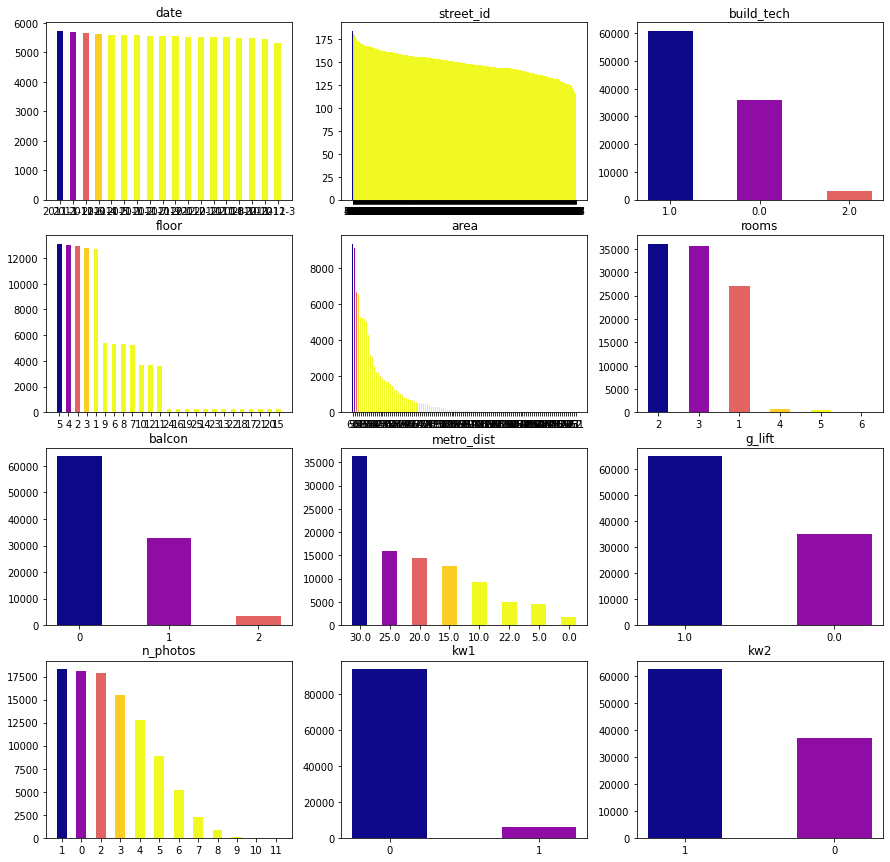

In [25]:
# распределения test, если заполнять округленными значениями из интервалов
fig, ax = plt.subplots(4, 3, figsize=(15, 15))

ax = ax.ravel()
width = 0.15

for i, column in tqdm(enumerate(data_tr.columns[1:13])):
    x = np.arange(0, 0.3 * len(data_tr['{}'.format(column)].value_counts()), 0.3)
    
    tick_label = data_tr['{}'.format(column)].value_counts().index
    
    ax[i].set_title('{}'.format(column))
    ax[i].bar(x, 
              data_tr['{}'.format(column)].value_counts(), 
              width, tick_label=tick_label,
              color= cm.plasma(x))

In [26]:
data_X_for_metro_dist_test = data_test.drop(['date', 'metro_dist', 'n_photos', 'floor', 'rooms'], 1)
data_X_for_metro_dist_test['build_tech'] = data_X_for_metro_dist_test['build_tech'].fillna(value=1)
data_X_for_metro_dist_test['g_lift'] = data_X_for_metro_dist_test['g_lift'].fillna(value=1)

X_for_metro_dist_test = data_X_for_metro_dist_test[data_test['metro_dist'].notna()]


Y_for_metro_dist_test = data_test['metro_dist']
Y_for_metro_dist_test = Y_for_metro_dist_test[data_test['metro_dist'].notna()]

X_pred_metro_dist_test = data_X_for_metro_dist_test[data_test['metro_dist'].isna()]

In [27]:
data_X_for_build_tech_test = data_test.drop(['date', 'build_tech', 'n_photos'], 1)
data_X_for_build_tech_test['metro_dist'] = data_X_for_build_tech_test['metro_dist'].fillna(value=20)
data_X_for_build_tech_test['g_lift'] = data_X_for_build_tech_test['g_lift'].fillna(value=1)

X_for_build_tech_test = data_X_for_build_tech_test[data_test['build_tech'].notna()]


Y_for_build_tech_test = data_test['build_tech']
Y_for_build_tech_test = Y_for_build_tech_test[data_test['build_tech'].notna()]

X_pred_build_tech_test = data_X_for_build_tech_test[data_test['build_tech'].isna()]

In [28]:
data_X_for_g_lift_test = data_test.drop(['date', 'g_lift', 'n_photos'], 1)
data_X_for_g_lift_test['metro_dist'] = data_X_for_g_lift_test['metro_dist'].fillna(value=20)
data_X_for_g_lift_test['build_tech'] = data_X_for_g_lift_test['build_tech'].fillna(value=1)

X_for_g_lift_test = data_X_for_g_lift_test[data_test['g_lift'].notna()]


Y_for_g_lift_test = data_test['g_lift']
Y_for_g_lift_test = Y_for_g_lift_test[data_test['g_lift'].notna()]

X_pred_g_lift_test = data_X_for_g_lift_test[data_test['g_lift'].isna()]

In [29]:
DC.fit(X_for_metro_dist_test, Y_for_metro_dist_test)
print('DC_accuracy_for_metro_dist: ', accuracy_score(Y_for_metro_dist_test, DC.predict(X_for_metro_dist_test)))

DC.fit(X_for_build_tech_test, Y_for_build_tech_test)
print('DC_accuracy_for_build_tech: ', accuracy_score(Y_for_build_tech_test, DC.predict(X_for_build_tech_test)))

DC.fit(X_for_g_lift_test, Y_for_g_lift_test)
print('DC_accuracy_for_g_lift: ', accuracy_score(Y_for_g_lift_test, DC.predict(X_for_g_lift_test)))

DC_accuracy_for_metro_dist:  0.22893770967640162
DC_accuracy_for_build_tech:  0.45992806683193144
DC_accuracy_for_g_lift:  0.5011276049100771


/Users/nikitaseleznev/PycharmProjects/TechnoSphereML/venv/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


In [30]:
RF.fit(X_for_metro_dist_test, Y_for_metro_dist_test)
print('RF_accuracy_for_metro_dist: ', accuracy_score(Y_for_metro_dist_test, RF.predict(X_for_metro_dist_test)))
Y_pred_metro_dist_test = RF.predict(X_pred_metro_dist_test)

RF.fit(X_for_build_tech_test, Y_for_build_tech_test)
print('RF_accuracy_for_build_tech: ', accuracy_score(Y_for_build_tech_test, RF.predict(X_for_build_tech_test)))
Y_pred_build_tech_test = RF.predict(X_pred_build_tech_test)

RF.fit(X_for_g_lift_test, Y_for_g_lift_test)
print('RF_accuracy_for_g_lift: ', accuracy_score(Y_for_g_lift_test, RF.predict(X_for_g_lift_test)))
Y_pred_g_lift_test = RF.predict(X_pred_g_lift_test)

RF_accuracy_for_metro_dist:  0.9831102043391842
RF_accuracy_for_build_tech:  0.9938813819192687
RF_accuracy_for_g_lift:  0.9814302026834142


In [31]:
data_test.loc[data_test['metro_dist'].isna(), 'metro_dist'] = Y_pred_metro_dist_test
data_test.loc[data_test['build_tech'].isna(), 'build_tech'] = Y_pred_build_tech_test
data_test.loc[data_test['g_lift'].isna(), 'g_lift'] = Y_pred_g_lift_test

In [32]:
# в итоге data_train выглядит так 
data_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,1,616,0.0,4,43,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,1738000
1,1,1,112,0.0,3,33,1,0,15.0,1.0,...,0,0,0,0,0,0,0,0,0,1169000
2,2,1,230,0.0,9,34,1,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,2821000
3,3,1,302,1.0,4,60,3,0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,5714000
4,4,1,578,0.0,3,49,2,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,1660000


In [33]:
# в итоге data_test выглядит так
data_test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,15,422,0.0,1,59,3,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,15,380,0.0,10,58,2,0,25.0,0.0,...,0,0,0,1,0,0,0,0,0,0
2,100002,15,362,1.0,3,54,2,0,10.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,15,34,0.0,4,35,1,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,15,562,0.0,4,56,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
parameters = {'max_features': [15, 20, 40], 
              'min_samples_leaf': [3, 5, 7],
              'max_depth': [15, 20, 30, 50]}
rfc = RandomForestRegressor(n_estimators=50, random_state=42, 
                             n_jobs=5, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=18, cv=skf, verbose=1)
gcv.fit(data_train.iloc[:, 1:-1], data_train.iloc[:, -1])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/nikitaseleznev/PycharmProjects/TechnoSphereML/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done  14 tasks      | elapsed:  1.5min
[Parallel(n_jobs=18)]: Done 180 out of 180 | elapsed:  7.6min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(n_estimators=50, n_jobs=5,
                                             oob_score=True, random_state=42),
             n_jobs=18,
             param_grid={'max_depth': [15, 20, 30, 50],
                         'max_features': [15, 20, 40],
                         'min_samples_leaf': [3, 5, 7]},
             verbose=1)

In [39]:
gcv.best_estimator_

RandomForestRegressor(max_depth=50, max_features=20, min_samples_leaf=3,
                      n_estimators=50, n_jobs=5, oob_score=True,
                      random_state=42)

In [49]:
price = gcv.predict(data_test.iloc[:, 1:])

In [51]:
res = pd.DataFrame({'price': price})

In [58]:
res_df = pd.concat([data_test[['id']], res], axis=1)

In [63]:
res_df.to_csv('price',index=False)